In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, precision_score, recall_score, f1_score
)
from scipy.stats import chi2_contingency, ttest_ind

import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv('D:/Uptrail Internship/Thirdproject/streamworks_user_data.csv')
    

# Display first few rows
print(df.head())


   user_id   age  gender signup_date last_active_date  country  \
0   1001.0  56.0   Other    02-04-25         13-07-25   France   
1   1002.0  69.0    Male    02-01-23         13-07-25    India   
2   1003.0  46.0    Male    21-08-22         13-07-25       UK   
3   1004.0  32.0   Other    14-09-23         13-07-25  Germany   
4   1005.0  60.0  Female    29-07-23         13-07-25    India   

  subscription_type  average_watch_hours  mobile_app_usage_pct  \
0          Standard                 42.6                  77.4   
1             Basic                 65.3                  98.0   
2           Premium                 40.1                  47.8   
3           Premium                  5.8                  53.2   
4          Standard                 32.7                  16.8   

   complaints_raised received_promotions referred_by_friend  is_churned  \
0                1.0                  No                 No         1.0   
1                4.0                  No                

In [240]:
# Summary statistics
print(df.describe())


           user_id          age  average_watch_hours  mobile_app_usage_pct  \
count  1498.000000  1497.000000          1496.000000           1498.000000   
mean   1750.871829    43.738811            39.903342             51.414419   
std     433.060980    15.083920            22.978288             28.580117   
min    1001.000000    18.000000             0.500000              0.000000   
25%    1376.250000    31.000000            19.450000             27.100000   
50%    1750.500000    44.000000            40.300000             52.700000   
75%    2125.750000    56.000000            59.800000             76.200000   
max    2500.000000    69.000000            79.900000            100.000000   

       complaints_raised   is_churned  monthly_fee  
count        1497.000000  1499.000000  1355.000000  
mean            2.498330     0.234156    10.180406  
std             1.706829     0.423612     3.310705  
min             0.000000     0.000000     5.990000  
25%             1.000000     0.0

In [241]:
df['gender'] = df['gender'].str.strip().str.title()
df['received_promotions'] = df['received_promotions'].str.strip().str.title()
df['referred_by_friend'] = df['referred_by_friend'].str.strip().str.title()

# Value counts for categorical columns
print(df['gender'].value_counts())
print(df['received_promotions'].value_counts())
print(df['referred_by_friend'].value_counts())
print(df['is_churned'].value_counts())

gender
Female    510
Other     506
Male      483
Name: count, dtype: int64
received_promotions
No     763
Yes    734
Name: count, dtype: int64
referred_by_friend
Yes    752
No     745
Name: count, dtype: int64
is_churned
0.0    1148
1.0     351
Name: count, dtype: int64


In [242]:

#Check for missing values

df = df.dropna(subset=['monthly_fee'])

#print(df['monthly_fee'].isnull().sum())
print(df['is_churned'].isnull().sum())
print(df['is_churned'].value_counts(dropna=False))
df = df.dropna(subset=['is_churned'])
print(df['is_churned'].isnull().sum())  # Should be 0


1
is_churned
0.0    1036
1.0     318
NaN       1
Name: count, dtype: int64
0


In [245]:
print(df['monthly_fee'].unique())
# Check how fee relates to subscription type
print(df.groupby('subscription_type')['monthly_fee'].mean())
# Fill missing monthly_fee based on subscription type averages
df['monthly_fee'] = df.groupby('subscription_type')['monthly_fee'].transform(lambda x: x.fillna(x.mean()))



[10.99  5.99 13.99  9.99 14.99  6.99   nan]
subscription_type
Basic        6.231901
Premium     14.226080
Standard    10.208679
Name: monthly_fee, dtype: float64


In [246]:
print(df.isnull().sum())

user_id                 2
age                     2
gender                  1
signup_date             2
last_active_date        2
country                 3
subscription_type       3
average_watch_hours     4
mobile_app_usage_pct    2
complaints_raised       2
received_promotions     3
referred_by_friend      2
is_churned              0
monthly_fee             3
dtype: int64


In [247]:
# Convert dates
df['signup_date'] = pd.to_datetime(df['signup_date'], errors='coerce')
df['last_active_date'] = pd.to_datetime(df['last_active_date'], errors='coerce')

# Fill missing dates with mode (most common date)
df['signup_date'].fillna(df['signup_date'].mode()[0], inplace=True)
df['last_active_date'].fillna(df['last_active_date'].mode()[0], inplace=True)

# Numeric columns: fill with mean
num_cols = ['age', 'average_watch_hours', 'mobile_app_usage_pct', 'complaints_raised']
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Ensure numeric type
    df[col].fillna(df[col].mean(), inplace=True)

# Categorical columns: fill with mode
cat_cols = ['gender', 'country', 'subscription_type', 'received_promotions', 'referred_by_friend']
for col in cat_cols:
    df[col] = df[col].astype(str).str.strip().str.title()
    df[col].fillna(df[col].mode()[0], inplace=True)
    df = df.dropna(subset=['user_id'])


# Final check
print(df.isnull().sum())


user_id                 0
age                     0
gender                  0
signup_date             0
last_active_date        0
country                 0
subscription_type       0
average_watch_hours     0
mobile_app_usage_pct    0
complaints_raised       0
received_promotions     0
referred_by_friend      0
is_churned              0
monthly_fee             3
dtype: int64


In [ ]:
print(df.dtypes)


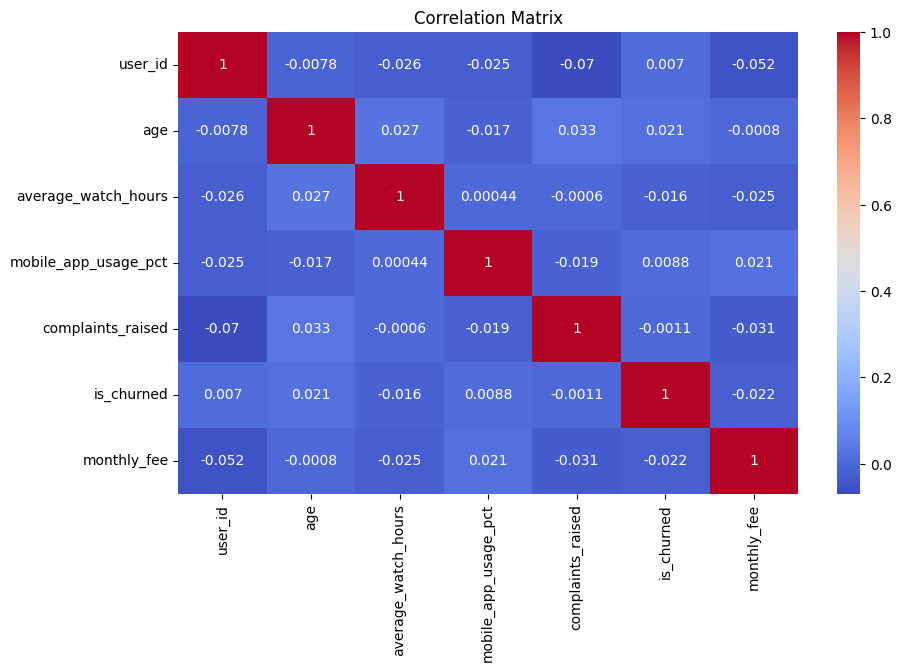

In [248]:

# Correlation matrix for numeric features
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = df[numeric_cols].corr()

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


In [249]:

#Prepare the data
# Convert to datetime
df['signup_date'] = pd.to_datetime(df['signup_date'],dayfirst=True, errors='coerce')
df['last_active_date'] = pd.to_datetime(df['last_active_date'],dayfirst=True, errors='coerce')

In [251]:
# Create tenure_days
df['tenure_days'] = (df['last_active_date'] - df['signup_date']).dt.days

In [252]:
# Create is_loyal
df['is_loyal'] = df['tenure_days'] > 180
df['is_loyal'] = df['is_loyal'].astype(int)

In [253]:
# Ensure column names are clean
df.columns = df.columns.str.strip().str.lower()

# Binary mapping
df['received_promotions'] = df['received_promotions'].map({'Yes': 1, 'No': 0})
df['referred_by_friend'] = df['referred_by_friend'].map({'Yes': 1, 'No': 0})

# Label encoding
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])  # Male/Female/Other -> 0/1/2




In [254]:
#handling missing values
# For simplicity, drop rows with any missing values
df = df.dropna()


In [255]:
#Statistical Analysis & Insights
def chi_square_test(col):
    # Drop rows with NaNs in col or is_churned
    sub_df = df[[col, 'is_churned']].dropna()

    # Create contingency table
    ct = pd.crosstab(sub_df[col], sub_df['is_churned'])

    # Only run if the table is valid
    if ct.empty or ct.shape[0] < 2 or ct.shape[1] < 2:
        print(f"Not enough variation in '{col}' for Chi-Square Test.\n")
        return

    chi2, p, dof, ex = chi2_contingency(ct)
    print(f"Chi-Square Test for {col}:")
    print(f"Chi2: {chi2:.2f}, p-value: {p:.4f}\n")


chi_square_test('gender')
chi_square_test('received_promotions')
chi_square_test('referred_by_friend')


Chi-Square Test for gender:
Chi2: 6.44, p-value: 0.0920

Chi-Square Test for received_promotions:
Chi2: 3.86, p-value: 0.0495

Chi-Square Test for referred_by_friend:
Chi2: 0.62, p-value: 0.4317



In [256]:
#T-test: Watch hours for churned vs. non-churned

churned = df[df['is_churned'] == 1]['average_watch_hours']
retained = df[df['is_churned'] == 0]['average_watch_hours']

t_stat, p_val = ttest_ind(churned, retained)
print(f"T-test: t-statistic = {t_stat:.2f}, p-value = {p_val:.4f}")


T-test: t-statistic = -0.61, p-value = 0.5391


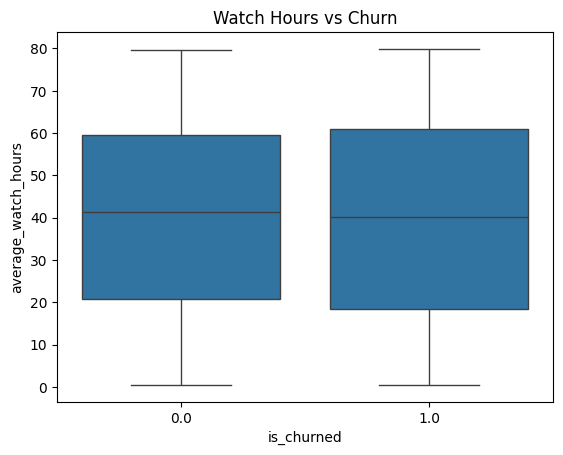

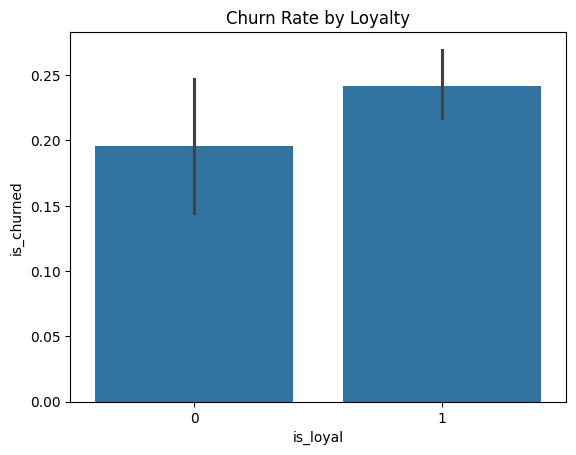

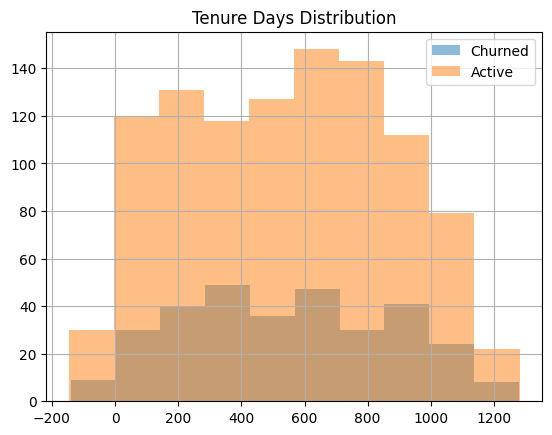

In [257]:
# Boxplot: watch hours vs churn
sns.boxplot(data=df, x='is_churned', y='average_watch_hours')
plt.title('Watch Hours vs Churn')
plt.show()

# Bar plot: churn rate by loyalty
sns.barplot(data=df, x='is_loyal', y='is_churned')
plt.title('Churn Rate by Loyalty')
plt.show()

# Histogram: tenure
df[df['is_churned'] == 1]['tenure_days'].hist(alpha=0.5, label='Churned')
df[df['is_churned'] == 0]['tenure_days'].hist(alpha=0.5, label='Active')
plt.legend()
plt.title('Tenure Days Distribution')
plt.show()


In [258]:
# Predictive Modeling

# Predictive Modeling

# === Imports ===
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# === Feature/target separation and train-test split ===
X = df.drop(columns=['user_id', 'signup_date', 'last_active_date', 'is_churned'])
y = df['is_churned']

# Keep only numeric features for modeling
X = X.select_dtypes(include='number')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

# === Preprocessing: Imputation + Scaling ===
preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Apply preprocessing
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

# === Model Training ===
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# === Prediction ===
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]


Training samples: 1075, Test samples: 269


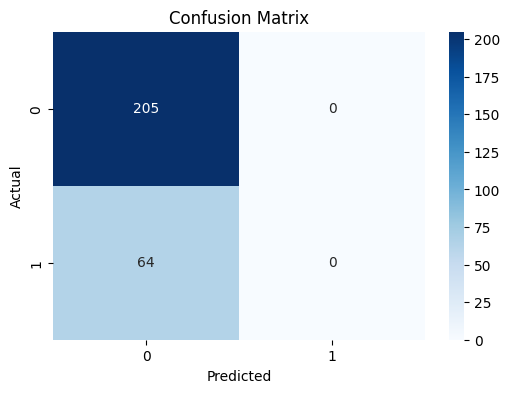

In [259]:
# === Evaluation ===

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



In [260]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Precision, Recall, F1 Score
print(f"Precision: {precision_score(y_test, y_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_pred):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")

Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      1.00      0.86       205
         1.0       0.00      0.00      0.00        64

    accuracy                           0.76       269
   macro avg       0.38      0.50      0.43       269
weighted avg       0.58      0.76      0.66       269

Precision: 0.00
Recall: 0.00
F1 Score: 0.00


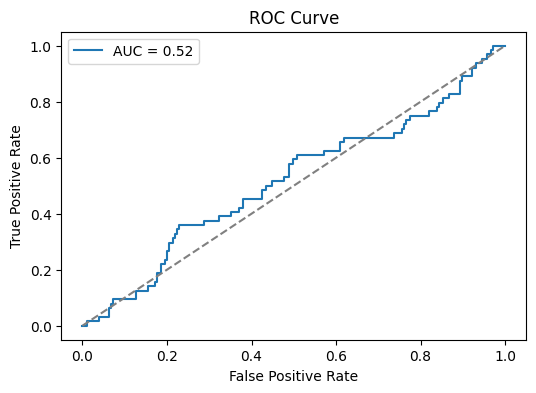

In [261]:
# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [262]:
# === Feature Importance ===

# Extract feature names from the original numeric columns
feature_names = X.columns  # Already selected numeric only

# Make sure the number of coefficients matches feature count
if len(feature_names) == len(model.coef_[0]):
    coefficients = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': model.coef_[0]
    })
    coefficients['abs_coef'] = coefficients['Coefficient'].abs()
    coefficients = coefficients.sort_values(by='abs_coef', ascending=False).drop(columns='abs_coef')

    print("Feature Importance (Logistic Regression Coefficients):")
    print(coefficients)
else:
    print("Mismatch between number of features and model coefficients.")

Feature Importance (Logistic Regression Coefficients):
                Feature  Coefficient
9              is_loyal     0.183818
5   received_promotions    -0.170174
8           tenure_days    -0.114750
1                gender    -0.090940
7           monthly_fee    -0.085296
6    referred_by_friend    -0.059280
0                   age     0.041236
2   average_watch_hours    -0.020640
3  mobile_app_usage_pct     0.006071
4     complaints_raised     0.000071


In [263]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],          # Regularization strength
    'penalty': ['l1', 'l2'],               # Norm used in penalization
    'solver': ['liblinear']                # Solver that supports both l1 and l2
}

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    LogisticRegression(),
    param_grid,
    cv=5,
    scoring='f1',  # or 'roc_auc'
    n_jobs=-1,
    verbose=1
)

# Fit grid search on scaled training data
grid_search.fit(X_train_scaled, y_train)

# Best model from GridSearch
best_logreg = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)

# Evaluate on test set
y_pred_best = best_logreg.predict(X_test_scaled)
y_proba_best = best_logreg.predict_proba(X_test_scaled)[:, 1]

print("Tuned Model F1 Score:", f1_score(y_test, y_pred_best))
print("Tuned Model AUC:", roc_auc_score(y_test, y_proba_best))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Tuned Model F1 Score: 0.0
Tuned Model AUC: 0.5


In [264]:
#Try a Second Model: Random Forest
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# Evaluate
print("Random Forest F1 Score:", f1_score(y_test, y_pred_rf))
print("Random Forest AUC:", roc_auc_score(y_test, y_proba_rf))

Random Forest F1 Score: 0.05970149253731343
Random Forest AUC: 0.5008003048780488


In [269]:
# Extract columns starting with 'country_'
country_cols = [col for col in df.columns if col.startswith('country_')]

# Use idxmax to get the one-hot column with value 1 per row (i.e., the actual country)
df['country'] = df[country_cols].idxmax(axis=1).str.replace('country_', '')


churn_by_country = df.groupby('country')['is_churned'].mean().sort_values(ascending=False)

print("Churn Rate by Country:")
print(churn_by_country)


ValueError: attempt to get argmax of an empty sequence

In [270]:
 #Subscription_type
# Extract subscription type
sub_cols = [col for col in df.columns if col.startswith('subscription_type_')]
df['subscription_type'] = df[sub_cols].idxmax(axis=1).str.replace('subscription_type_', '')

# Group by it
churn_by_sub = df.groupby('subscription_type')['is_churned'].mean().sort_values(ascending=False)
print("Churn Rate by Subscription Type:")
print(churn_by_sub)



ValueError: attempt to get argmax of an empty sequence

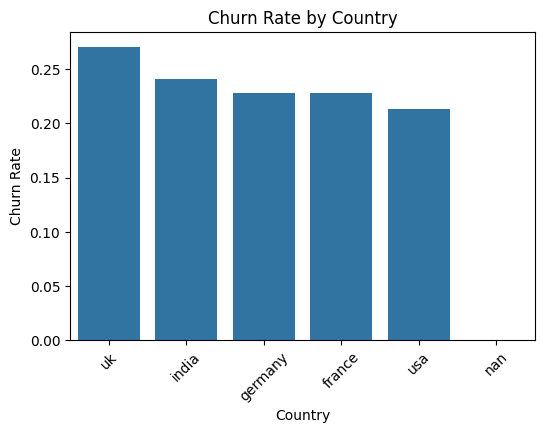

In [268]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.barplot(x=churn_by_country.index, y=churn_by_country.values)
plt.title("Churn Rate by Country")
plt.ylabel("Churn Rate")
plt.xlabel("Country")
plt.xticks(rotation=45)
plt.show()
